In [1]:
%reload_ext autoreload
%autoreload 2

In [14]:
import bokeh.plotting

In [13]:
!pip install bokeh

    100% |████████████████████████████████| 19.3MB 1.9MB/s ta 0:00:01
  Stored in directory: /home/nikolay/.cache/pip/wheels/f7/9c/c2/198b62e1376d06184c7cd0ad9e055f91de2f241e3820cb9313
Successfully built bokeh
You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean 
from insightface.embedder import InsightfaceEmbedder
import pandas as pd
from glob import glob
from tqdm import tqdm
from time import time

Using TensorFlow backend.
/home/nikolay/.pyenv/versions/3.7.3/envs/main/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nikolay/.pyenv/versions/3.7.3/envs/main/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nikolay/.pyenv/versions/3.7.3/envs/main/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [3]:
model_path = "models/model-r34-amf/model"
embedder = InsightfaceEmbedder(model_path=model_path, epoch_num='0000', image_size=(112, 112),
                               no_face_raise=False,
                               MTCNN_min_face_size=50, MTCNN_steps_threshold=[0.2, 0.2, 0.9])


loading models/model-r34-amf/model 0


In [4]:
dfPeople = pd.DataFrame()
dfPeople['name'] = 'object'
dfPeople['path'] = 'object'
dfPeople['embedding'] = 'object'
dfPeople['bbox'] = 'object'

In [5]:
faceDetection_imgHeight = 512

path = 'data/People/'

def get_embeddings(path):
    people_list = os.listdir(path)
    
    count = 0
    print(f'Обнаружено {len(people_list)} индивидов')
    print(f'Создание базы эмбеддингов')
    
    for man in tqdm(people_list):
        photos = os.listdir(f'data/People/{man}')
        for photo in photos:
            img_path = f'data/People/{man}/{photo}'
            img = cv2.imread(img_path)
            emb_img, bboxes_img, points = embedder.embed_image(img, faceDetection_imgHeight=faceDetection_imgHeight)
            dfPeople.at[count, 'name'] = man
            dfPeople.at[count, 'path'] = img_path
            dfPeople.at[count, 'embedding'] = emb_img[0]
            dfPeople.at[count, 'bbox']      = bboxes_img[0]
            count += 1
    return dfPeople

dfPeople = get_embeddings(path)

  0%|          | 0/2 [00:00<?, ?it/s]

Обнаружено 2 индивидов
Создание базы эмбеддингов



100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


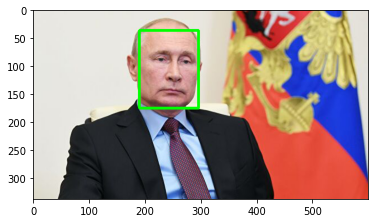

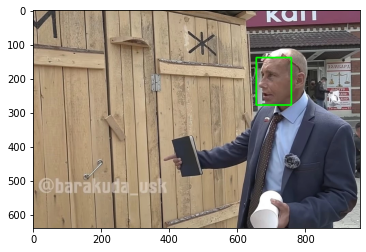

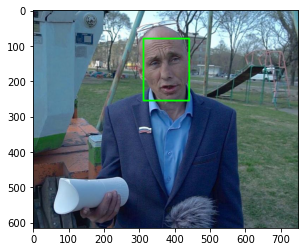

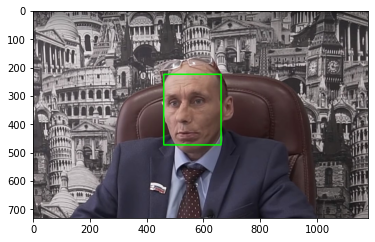

In [6]:
def show_baza(dfPeople):
    for i in dfPeople.index:
        path = dfPeople.at[i, 'path']
        img = plt.imread(path)
        startPoint = dfPeople.at[i, 'bbox'][:2]
        endPoint = dfPeople.at[i, 'bbox'][2:4]
        cv2.rectangle(img, tuple(startPoint), tuple(endPoint), (0,255,0), 4)
        plt.imshow(img)
        plt.show()
        
### Averagin embedding
def average_embeddings(dfPeople):
    df = pd.DataFrame()
    df['name'] = 'name'
    df['embedding'] = 'embedding'

    for ind, name in enumerate(dfPeople['name'].value_counts().index):
        person = dfPeople[dfPeople['name'] == name]
        df.at[ind, 'name'] = name
        df.at[ind, 'embedding'] = np.average(person['embedding'].values, axis=0)
    return df

show_baza(dfPeople)

In [7]:
def video_inference(embedder, dfPeople, input_video_path, faceDetection_imgHeight=300, frames_skip=10, final_frame_rate=3,
                   output_vide_path='output.avi'):
    tt = time()
    # Open the input movie file
    input_movie = cv2.VideoCapture(input_video_path)
    length = int(input_movie.get(cv2.CAP_PROP_FRAME_COUNT))
    frame = input_movie.read()[1]
    h,w,c = frame.shape

    # Create an output movie file (make sure resolution/frame rate matches input video!)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    output_movie = cv2.VideoWriter(output_vide_path, fourcc, final_frame_rate, (w, h))


    frame_number = 0
    while True:
        frame_number += 1
        # Grab a single frame of video
        ret, bgr_frame = input_movie.read()
        # Quit when the input video file ends
        if not ret:
            break

        if frame_number % frames_skip != 0:
            continue 

        # Find all the faces and face encodings in the current frame of video
        face_encodings, face_locations, face_points = embedder.embed_image(bgr_frame, faceDetection_imgHeight=faceDetection_imgHeight)
        if face_encodings != None:
            face_names = []
            dists_list = []
            for face_encoding in face_encodings:
                # See if the face is a match for the known face(s)
                tolerance = 1
                distances = np.linalg.norm(dfPeople['embedding'].values.tolist() - face_encoding, axis=1)
                matches = distances <= tolerance
                min_dist = min(distances)
                dists_list.append(min_dist)
                name = 'Unknown'
                if matches.sum() > 0:
                    name = dfPeople['name'][matches].value_counts().index[0]
                face_names.append(name)

            # Label the results
            ind = 0
            for (left, top, right, bottom), name in zip(face_locations, face_names):
                # Draw a box around the face
                # Draw a label with a name below the face
                if name == 'Nalivkin':
                    cv2.rectangle(bgr_frame, (left, top), (right, bottom), (0, 255, 255), 4)
    #                 cv2.rectangle(bgr_frame, (left, bottom - 10), (right, bottom), (0, 255, 0), cv2.FILLED)
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(bgr_frame, f"{name}, {str(dists_list[ind])[:4]}", (left, bottom), font, 0.7, 
                                (0, 255, 0), 1)
                else:
                    cv2.rectangle(bgr_frame, (left, top), (right, bottom), (0, 255, 0), 4)
    #                 cv2.rectangle(bgr_frame, (left, bottom - 10), (right, bottom), (0, 0, 255), cv2.FILLED)
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(bgr_frame, f"{name}, {str(dists_list[ind])[:4]}", (left, bottom), font, 0.7,
                                (0, 255, 0), 1)

                ind += 1


        # Write the resulting image to the output video file
        print("Writing frame {} / {}".format(frame_number, length))
        output_movie.write(bgr_frame)
    #     plt.imshow(bgr_frame[:,:,[2,1,0]])
    #     plt.show()

    # All done!
    input_movie.release()
    cv2.destroyAllWindows()

    print("Total time spend: time() - tt)")
    
input_video_path = "data/Video/Виталий Наливкин комментирует свой арест.mp4"
output_vide_path = "output.avi"
video_inference(embedder=embedder, dfPeople=dfPeople, 
               input_video_path=input_video_path, output_vide_path=output_vide_path)

Writing frame 10 / 1727
Writing frame 20 / 1727
Writing frame 30 / 1727
Writing frame 40 / 1727
Writing frame 50 / 1727
Writing frame 60 / 1727
Writing frame 70 / 1727
Writing frame 80 / 1727
Writing frame 90 / 1727


KeyboardInterrupt: 

In [8]:
#Mobilenet - 21.42 length of the descriptor - 128 -
#Resnet34 - 41 length of the descriptor - 512 - 
#Resnet100 - 41 length of the descriptor - 512 - 

In [10]:
from ipywebrtc import VideoStream
# commented out since it increases the size of the notebook a lot
video = VideoStream.from_file('data/Video/Виталий Наливкин комментирует свой арест.mp4')
video

VideoStream(video=Video(value=b'\x00\x00\x00\x18ftypmp42\x00\x00\x00\x00isommp42\x00\x00a\'moov\x00\x00\x00lmv…

In [8]:
import ipywidgets as widgets

play_button = widgets.ToggleButton(description="Play")
widgets.jslink((play_button, 'value'), (video, 'playing'))
widgets.VBox(children=[video, play_button])
